# 1 - Synthetic Dataset Creation

In [95]:
# 🔧 Core dependencies for generation, scoring, and analysis
# 📦 Installation (run this cell first if packages are missing)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install transformers scikit-learn
# !pip install pandas matplotlib seaborn tqdm
# !pip install sentence-transformers


## 1.1 Generate the Dataset

In [96]:
# Imports and Setup
import random
import json
import torch
from pathlib import Path
from transformers import BertTokenizer, BertModel, BartTokenizer, BartModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

In [97]:
# Supress Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [100]:
# Configuration: TLDs, Categories, Keywords, Adjectives, Business Types

# === Domain extension groups ===
TLD_GROUPS = {
    "common": [".com", ".net", ".org"],
    "tech": [".ai", ".tech", ".dev"],
    "ecommerce": [".store", ".shop", ".co"],
    "creative": [".studio", ".design", ".media"],
    "health": [".health", ".care", ".clinic"],
    "legal": [".legal", ".law"],
    "education": [".academy", ".edu"],
    "food": [".kitchen", ".menu"],
    "coffee": [".cafe", ".coffee"]
}

# === Categories with adjectives, business types, keywords ===
DOMAIN_CATEGORIES = {
    "food": {
        "adjectives": ["organic", "local", "vegan", "healthy", "homemade"],
        "business_types": ["meal service", "snack bar", "vegan diner", "organic eatery"],
        "keywords": ["organic", "local", "meal", "plate", "vegan", "snack", "deli", "healthy", "prep", "bites",
                     "grill", "menu", "dish", "eat", "serve", "flavor", "kitchen", "taste", "market", "chef"],
        "extension_keys": ["common", "food"]
    },
    "coffee": {
        "adjectives": ["cozy", "artisan", "independent", "sustainable", "premium"],
        "business_types": ["coffee shop", "espresso bar", "cafe", "roastery"],
        "keywords": ["beans", "brew", "cafe", "grind", "latte", "espresso", "blend", "java", "mug", "steam",
                     "barista", "pour", "aroma", "cup", "beanery", "drip", "grounds", "sips", "filter", "darkroast"],
        "extension_keys": ["common", "coffee"]
    },
    "tech": {
        "adjectives": ["innovative", "cloud-based", "scalable", "cutting-edge", "intelligent"],
        "business_types": ["AI SaaS startup", "blockchain platform", "mobile app developer"],
        "keywords": ["cloud", "bot", "data", "ai", "stack", "code", "dev", "logic", "compute", "neural",
                     "node", "cyber", "script", "deploy", "stream", "tensor", "model", "byte", "core", "matrix"],
        "extension_keys": ["common", "tech"]
    },
    "health": {
        "adjectives": ["holistic", "mindful", "therapeutic", "gentle", "wellness-focused"],
        "business_types": ["yoga studio", "nutritionist", "wellness center"],
        "keywords": ["calm", "vital", "fit", "care", "wellness", "med", "yoga", "therapy", "balance", "relax",
                     "mind", "body", "clinic", "heal", "energy", "breathe", "flow", "zen", "pulse", "restore"],
        "extension_keys": ["common", "health"]
    },
    "legal": {
        "adjectives": ["trusted", "professional", "experienced", "reputable", "compliant"],
        "business_types": ["law firm", "legal consultancy", "compliance office"],
        "keywords": ["legal", "justice", "firm", "counsel", "law", "brief", "case", "court", "advocate", "barrister",
                     "defense", "claim", "compliance", "rights", "ruling", "precedent", "trial", "witness", "verdict", "legaltech"],
        "extension_keys": ["common", "legal"]
    },
    "education": {
        "adjectives": ["interactive", "accessible", "global", "self-paced", "innovative"],
        "business_types": ["online academy", "language school", "tutoring platform"],
        "keywords": ["learn", "teach", "edu", "academy", "school", "class", "study", "brain", "train", "instruct",
                     "mentor", "pupil", "professor", "course", "lesson", "homework", "quiz", "read", "skills", "curriculum"],
        "extension_keys": ["common", "education"]
    },
    "ecommerce": {
        "adjectives": ["sustainable", "ethical", "minimalist", "convenient", "affordable"],
        "business_types": ["online shop", "eco product store", "fashion boutique"],
        "keywords": ["shop", "cart", "store", "buy", "eco", "green", "market", "checkout", "sale", "goods",
                     "pack", "brand", "vendor", "retail", "product", "online", "fashion", "style", "deal", "order"],
        "extension_keys": ["common", "ecommerce"]
    }
}

LOCATIONS = ["New York", "Austin", "San Francisco", "Los Angeles", "Berlin", "Beirut", "Brussels", "Montreal", "Paris"]
SUB_LOCATIONS = ["downtown", "midtown", "uptown", "old town", "main street", "the suburbs of", "the business district of"]

# # === Related categories for wrong-keyword generation ===
# RELATED_CATEGORIES = {
#     "food": ["coffee", "ecommerce"],
#     "coffee": ["food", "ecommerce"],
#     "tech": ["education", "ecommerce"],
#     "education": ["tech", "legal"],
#     "health": ["legal", "education"],
#     "legal": ["health", "education"],
#     "ecommerce": ["tech", "food"]
# }

# # === Quality mode weights ===
# QUALITY_MODES_WEIGHTS = {
#     "clean": 0.6,
#     "with_noise": 0.1,
#     "mismatched_extensions": 0.1,
#     "mixed_category_keywords": 0.1,
#     "wrong_category_keywords_soft": 0.05,
#     "wrong_category_keywords_strict": 0.05
# }


In [101]:
# # Extension Resolver
# def resolve_extensions(keys):
#     extensions = set()
#     for key in keys:
#         extensions.update(TLD_GROUPS.get(key, []))
#     return list(extensions)


In [139]:
# Scoring Logic Functions
BERT_TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")
BERT_MODEL = BertModel.from_pretrained("bert-base-uncased")
BART_TOKENIZER = BartTokenizer.from_pretrained("facebook/bart-base")
BART_MODEL = BartModel.from_pretrained("facebook/bart-base")
SBERT_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

# def encode(text, model, tokenizer):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).numpy()
def encode(text, model, tokenizer=None):
    if(model == "sbert"):
        return SBERT_MODEL.encode([text])
    else:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()

def compute_confidence(domain, business_desc, method="heuristic"):
    bus_desc_lower = business_desc.lower()

    if method == "heuristic":
        # score = 0.7
        # if keyword_combo.replace(" ", "") in domain:
        #     score += 0.1
        # if ".com" in domain:
        #     score += 0.05
        # if len(domain) > 20:
        #     score -= 0.1
        # if any(char.isdigit() or char == '-' for char in domain):
        #     score -= 0.2
        # return round(min(max(score, 0.0), 1.0), 2)
        score = 0.9
        if any(word in domain for word in bus_desc_lower.split()):
            score += 0.3
        if ".com" in domain:
            score += 0.15
        if len(domain) > 20:
            score -= 0.1
        if any(c.isdigit() or c == '-' for c in domain):
            score -= 0.2
        return round(min(max(score, 0.0), 1.0), 2)

    elif method == "bert":
        domain_vec = encode(domain.replace(".", " "), BERT_MODEL, BERT_TOKENIZER)
        keyword_vec = encode(bus_desc_lower, BERT_MODEL, BERT_TOKENIZER)
        return round(float(cosine_similarity(domain_vec, keyword_vec)[0][0]), 2)

    elif method == "bart":
        domain_vec = encode(domain.replace(".", " "), BART_MODEL, BART_TOKENIZER)
        keyword_vec = encode(bus_desc_lower, BART_MODEL, BART_TOKENIZER)
        return round(float(cosine_similarity(domain_vec, keyword_vec)[0][0]), 2)

    elif method == "sbert":
        d_vec = encode(domain.replace(".", " "), "sbert")
        k_vec = encode(bus_desc_lower, "sbert")
        return round(float(cosine_similarity(d_vec, k_vec)[0][0]), 2)

    elif method == "ensemble":
        h = compute_confidence(domain, bus_desc_lower, method="heuristic")
        b = compute_confidence(domain, bus_desc_lower, method="bert")
        ba = compute_confidence(domain, bus_desc_lower, method="bart")
        s = compute_confidence(domain, bus_desc_lower, "sbert")
        return round(0.5 * h + 0.2 * b + 0.15 * ba + 0.15 * s, 2)

    else:
        raise ValueError("Unknown confidence method")


In [105]:
# Domain Generator
# def generate_domains(keywords, extensions):
#     num_keywords = random.randint(1, 5)
#     selected = random.sample(keywords, num_keywords)
#     base = "".join(selected).lower()
#     return base, [f"{base}{random.choice(extensions)}"]

def generate_domains(category):
    def resolve_extensions(keys):
        extensions = set()
        for key in keys:
            extensions.update(TLD_GROUPS.get(key, []))
        return list(extensions)

    config = DOMAIN_CATEGORIES[category]
    keywords = config["keywords"]
    extensions = resolve_extensions(config["extension_keys"])

    QUALITY_MODES_WEIGHTS = {
        "clean": 0.6,
        "with_noise": 0.1,
        "mismatched_extensions": 0.1,
        "mixed_category_keywords": 0.1,
        "wrong_category_keywords_soft": 0.05,
        "wrong_category_keywords_strict": 0.05
    }
    mode = random.choices(list(QUALITY_MODES_WEIGHTS), weights=list(QUALITY_MODES_WEIGHTS.values()))[0]

    def clean():
        selected = random.sample(keywords, k=random.randint(1, 5))
        base = "".join(selected).lower()
        return [f"{base}{random.choice(extensions)}"]

    def with_noise():
        selected = random.sample(keywords, k=random.randint(1, 3))
        base = "".join(selected).lower() + random.choice(["-123", "99", "xyz", "-dev", "000"])
        return [f"{base}{random.choice(extensions)}"]

    def mismatched_extensions():
        selected = random.sample(keywords, k=random.randint(2, 4))
        base = "".join(selected).lower()
        wrong_keys = list(set(TLD_GROUPS.keys()) - set(config["extension_keys"]))
        wrong_exts = resolve_extensions(random.sample(wrong_keys, k=1))
        return [f"{base}{random.choice(wrong_exts)}"]

    def mixed_category_keywords():
        other = random.choice(list(set(DOMAIN_CATEGORIES) - {category}))
        foreign = DOMAIN_CATEGORIES[other]["keywords"]
        selected = random.sample(keywords, k=random.randint(1, 2)) + random.sample(foreign, k=random.randint(1, 2))
        base = "".join(selected).lower()
        return [f"{base}{random.choice(extensions)}"]

    def wrong_category_keywords(soft=True):
        RELATED_CATEGORIES = {
            "food": ["coffee", "ecommerce"],
            "coffee": ["food", "ecommerce"],
            "tech": ["education", "ecommerce"],
            "education": ["tech", "legal"],
            "health": ["legal", "education"],
            "legal": ["health", "education"],
            "ecommerce": ["tech", "food"]
        }
        if soft and category in RELATED_CATEGORIES:
            pool = RELATED_CATEGORIES[category]
        else:
            pool = list(set(DOMAIN_CATEGORIES) - {category})
        wrong_cat = random.choice(pool)
        wrong_keywords = DOMAIN_CATEGORIES[wrong_cat]["keywords"]
        selected = random.sample(wrong_keywords, k=random.randint(2, 4))
        base = "".join(selected).lower()
        return [f"{base}{random.choice(extensions)}"]

    if mode == "clean":
        return clean(), mode
    elif mode == "with_noise":
        return with_noise(), mode
    elif mode == "mismatched_extensions":
        return mismatched_extensions(), mode
    elif mode == "mixed_category_keywords":
        return mixed_category_keywords(), mode
    elif mode == "wrong_category_keywords_soft":
        return wrong_category_keywords(soft=True), mode
    else:
        return wrong_category_keywords(soft=False), mode

In [140]:
# Business Entry Generator
# def generate_business_entry(category, location, extensions, config, method="heuristic"):
#     adjective = random.choice(config["adjectives"])
#     business_type = random.choice(config["business_types"])
#     description = f"A {adjective} {business_type} based in {location}"
#     base, domains = generate_domains(config["keywords"], extensions)


#     suggestions = [
#         {"domain": d, "confidence": compute_confidence(d, base.split(), method)}
#         for d in domains
#     ]
#     return {
#         "business_description": description,
#         "domain_suggestions": suggestions,
#         "category": category
#     }


# def generate_business_entry(category, location, extensions, config, method="ensemble"):
#     adjective = random.choice(config["adjectives"])
#     business_type = random.choice(config["business_types"])

#     article = "An" if starts_with_vowel(adjective) else "A"

#     description = f"{article} {adjective} {business_type} based in {location}"

#     base, domains = generate_domains(config["keywords"], extensions)


#     suggestions = []
#     for d in domains:
#         if method == "ensemble":
#             scores = {
#                 "heuristic": compute_confidence(d, base.split(), method="heuristic"),
#                 "bert": compute_confidence(d, base.split(), method="bert"),
#                 "bart": compute_confidence(d, base.split(), method="bart"),
#             }
#             confidence = round(
#                 0.5 * scores["heuristic"] +
#                 0.3 * scores["bert"] +
#                 0.2 * scores["bart"], 2
#             )
#         else:
#             score = compute_confidence(d, base.split(), method=method)
#             scores = {method: score}
#             confidence = score

#         suggestions.append({
#             "domain": d,
#             "confidence": confidence,
#             "scores": scores
#         })

#     return {
#         "business_description": description,
#         "domain_suggestions": suggestions,
#         "category": category
#     }

def generate_business_entry(method="ensemble"):
    def starts_with_vowel(word):
        return word[0].lower() in 'aeiou'
    category = random.choice(list(DOMAIN_CATEGORIES.keys()))
    config = DOMAIN_CATEGORIES[category]
    location = f"{random.choice(SUB_LOCATIONS)} {random.choice(LOCATIONS)}"
    extensions = resolve_extensions(config["extension_keys"])
    adjective = random.choice(config["adjectives"])
    business_type = random.choice(config["business_types"])

    article = "An" if starts_with_vowel(adjective) else "A"

    description = f"{article} {adjective} {business_type} based in {location}"
    # base, domains = generate_domains(config["keywords"], extensions)

    domains, quality_mode = generate_domains(category)


    suggestions = []
    for d in domains:
        if method == "ensemble":
            scores = {
                "heuristic": compute_confidence(d, description, method="heuristic"),
                "bert": compute_confidence(d, description, method="bert"),
                "bart": compute_confidence(d, description, method="bart"),
                "sbert": compute_confidence(d, description, method="bart"),
            }
            confidence = round(
                0.7 * scores["heuristic"] +
                0.1 * scores["bert"] +
                0.1 * scores["bart"] +
                0.1 * scores["sbert"], 2
            )
        else:
            score = compute_confidence(d, description, method=method)
            scores = {method: score}
            confidence = score

        suggestions.append({
            "domain": d,
            "confidence": confidence,
            "scores": scores
        })

    return {
        "business_description": description,
        "domain_suggestions": suggestions,
        "location": location,
        "category": category,
        "quality_mode": quality_mode
    }



In [115]:
# Dataset Generator
def create_dataset(num_entries=100, method="heuristic"):
    entries = []
    # for _ in range(num_entries):
    for _ in tqdm(range(num_entries), desc="Generating dataset"):
        # category = random.choice(list(DOMAIN_CATEGORIES.keys()))
        # config = DOMAIN_CATEGORIES[category]
        # location = f"{random.choice(SUB_LOCATIONS)} {random.choice(LOCATIONS)}"
        # extensions = resolve_extensions(config["extension_keys"])
        entry = generate_business_entry(method)
        entries.append(entry)
    return entries

# Save Function
def save_dataset(entries, filename="dataset.jsonl", output_format="jsonl"):
    path = Path(filename)
    with open(path, "w") as f:
        if output_format == "jsonl":
            for entry in entries:
                f.write(json.dumps(entry) + "\n")
        elif output_format == "json":
            json.dump(entries, f, indent=2)
        else:
            raise ValueError("Invalid output format")
    print(f"\n✅ Saved {len(entries)} entries to {path}")

# Append Function
def append_dataset(entries, filename="dataset.jsonl", output_format="jsonl", mode="a"):
    path = Path(filename)
    with open(path, mode) as f:
        if output_format == "jsonl":
            for entry in entries:
                f.write(json.dumps(entry) + "\n")
        elif output_format == "json":
            raise NotImplementedError("Appending to .json not supported.")
        else:
            raise ValueError("Invalid output format: use 'jsonl'")
    print(f"✅ Appended {len(entries)} entries to {path}")



In [108]:
# === 🚀 Unified generation function ===
def run_generation(
    dataset_size: int,
    output_path: str,
    confidence_method: str = "ensemble",
    mode: str = "append",
    batch_size: int = None,
    num_batches: int = None
):
    assert dataset_size > 0, "DATASET_SIZE must be > 0"

    if batch_size and num_batches:
        assert batch_size * num_batches == dataset_size, (
            f"Inconsistent: {batch_size} × {num_batches} ≠ {dataset_size}"
        )
    elif batch_size:
        num_batches = dataset_size // batch_size
        assert batch_size * num_batches == dataset_size, (
            f"DATASET_SIZE must be divisible by BATCH_SIZE"
        )
    elif num_batches:
        batch_size = dataset_size // num_batches
        assert batch_size * num_batches == dataset_size, (
            f"DATASET_SIZE must be divisible by NUM_BATCHES"
        )
    else:
        raise ValueError("You must define at least BATCH_SIZE or NUM_BATCHES")

    print(f"📦 Generating {dataset_size} entries in {num_batches} batches of {batch_size} using '{confidence_method}'...")

    for batch_num in tqdm(range(num_batches), desc="📊 Batches"):
        entries = create_dataset(num_entries=batch_size, method=confidence_method)

        if batch_num == 0 and mode == "save":
            save_dataset(entries, filename=output_path)
        else:
            append_dataset(entries, filename=output_path)

    print(f"✅ Completed generation: {dataset_size} entries → {output_path}")


In [141]:
# Modify the values in this cell then run it to generate the dataset of your desired size.

OUTPUT_PATH = "synthetic_domain_dataset_v2.jsonl"
DATASET_SIZE = 1000
BATCH_SIZE = 100     # Set this OR NUM_BATCHES (not both unless they match DATASET_SIZE)
NUM_BATCHES = None  # ← Use None if you're setting BATCH_SIZE
MODE = "save"     # "save" or "append"
CONFIDENCE_METHOD = "ensemble"  # "heuristic", "bert", "bart", or "ensemble"

run_generation(
    dataset_size=DATASET_SIZE,
    output_path=OUTPUT_PATH,
    confidence_method=CONFIDENCE_METHOD,
    mode=MODE,
    batch_size=BATCH_SIZE,
    num_batches=NUM_BATCHES
)


📦 Generating 1000 entries in 10 batches of 100 using 'ensemble'...


📊 Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



✅ Saved 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v2.jsonl
✅ Completed generation: 1000 entries → synthetic_domain_dataset_v2.jsonl


## 1.2 Analyse the Dataset

In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json


In [136]:
# Load and Flatten Dataset
def load_jsonl(filepath):
    data = []
    with open(filepath, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data

def flatten_dataset(json_data):
    rows = []
    for entry in json_data:
        desc = entry["business_description"]
        cat = entry["category"]
        for sug in entry["domain_suggestions"]:
            row = {
                "domain": sug["domain"],
                "confidence": sug["confidence"],
                "category": cat,
                "description": desc,
            }
            for method, score in sug.get("scores", {}).items():
                row[f"score_{method}"] = score
            rows.append(row)
    return pd.DataFrame(rows)

# 👇 Load and flatten
raw_data = load_jsonl("synthetic_domain_dataset_v2.jsonl")
df = flatten_dataset(raw_data)
print(f"✅ Loaded {len(df)} domain entries")
df.head()


✅ Loaded 1000 domain entries


,domain,confidence,category,description,score_heuristic,score_bert,score_bart,score_sbert
0,defenselegaljusticetrial.legal,0.79,legal,A trusted legal consultancy based in the busin...,1.0,0.56,0.40,0.40
1,quizpupillearnmentor.edu,0.66,education,An accessible language school based in midtown...,0.8,0.55,0.35,0.35
2,logiccorestackcyber.tech,0.69,tech,An intelligent mobile app developer based in d...,0.8,0.58,0.46,0.46
3,tastemarket.kitchen,0.80,food,A vegan snack bar based in midtown Paris,1.0,0.58,0.43,0.43
4,scriptmatrixbot-123.tech,0.57,tech,An innovative blockchain platform based in the...,0.6,0.64,0.40,0.40


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


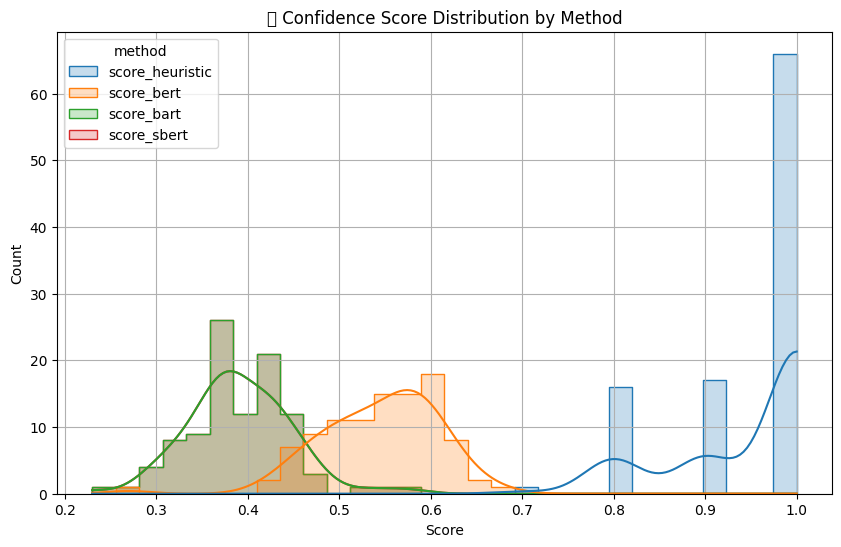

In [128]:
# Confidence Score Distribution
plt.figure(figsize=(10, 6))
score_cols = [col for col in df.columns if col.startswith("score_")]
df_long = df.melt(id_vars=["domain"], value_vars=score_cols, var_name="method", value_name="score")

sns.histplot(data=df_long, x="score", hue="method", bins=30, kde=True, element="step")
plt.title("🔍 Confidence Score Distribution by Method")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


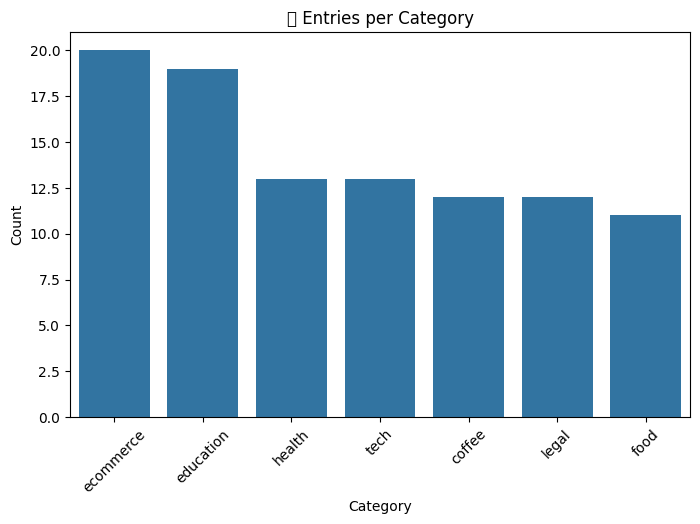

In [129]:
# Category Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="category", order=df["category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("📊 Entries per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128289 (\N{INPUT SYMBOL FOR LATIN SMALL LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


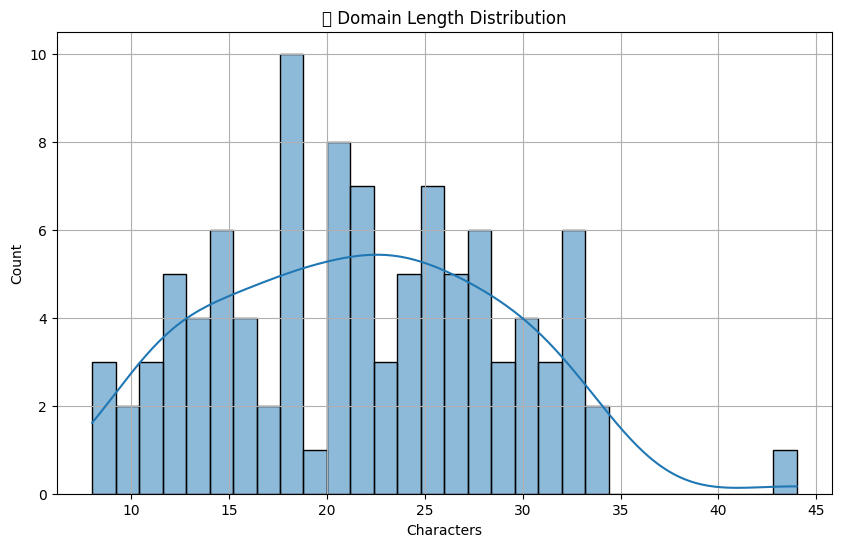

In [130]:
# Domain Length Distribution
df["domain_length"] = df["domain"].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df["domain_length"], bins=30, kde=True)
plt.title("🔡 Domain Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


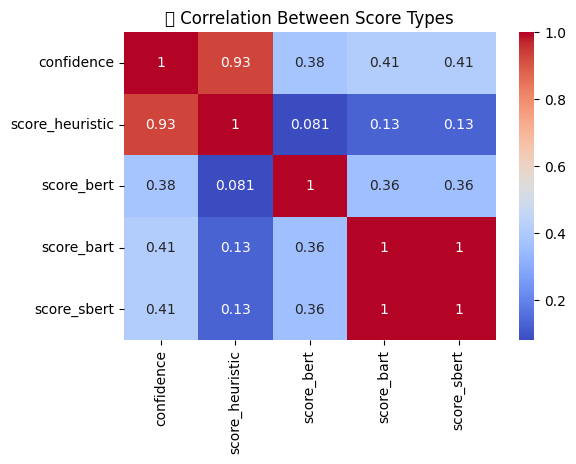

In [131]:
# Correlation Between Score Types
plt.figure(figsize=(6, 4))
sns.heatmap(df[[c for c in df.columns if c.startswith("score_") or c == "confidence"]].corr(), annot=True, cmap="coolwarm")
plt.title("🔁 Correlation Between Score Types")
plt.show()


In [137]:
# Outlier Examples
# 🔍 Show extreme cases
low_conf = df[df["confidence"] < 0.75].sort_values("confidence")
high_conf = df[df["confidence"] > 0.75].sort_values("confidence", ascending=False)

print("🧊 Low-confidence examples:")
display(low_conf.head())

print("🔥 High-confidence examples:")
display(high_conf.head())


🧊 Low-confidence examples:


,domain,confidence,category,description,score_heuristic,score_bert,score_bart,score_sbert
373,localsnackmenu000.net,0.53,food,An organic vegan diner based in uptown San Fra...,0.6,0.46,0.40,0.40
583,flowzenenergy-123.net,0.54,health,A holistic yoga studio based in midtown New York,0.6,0.52,0.36,0.36
46,bytestreamlogic000.org,0.55,tech,An intelligent mobile app developer based in d...,0.6,0.50,0.43,0.43
177,scriptdatamodel000.org,0.55,tech,An intelligent AI SaaS startup based in uptown...,0.6,0.54,0.43,0.43
527,pour99.net,0.57,coffee,An artisan espresso bar based in uptown Los An...,0.7,0.41,0.32,0.32


🔥 High-confidence examples:


,domain,confidence,category,description,score_heuristic,score_bert,score_bart,score_sbert
350,teachinstruct.academy,0.85,education,An interactive tutoring platform based in upto...,1.0,0.71,0.55,0.55
655,classschoolskillspupilquiz.academy,0.84,education,An accessible language school based in main st...,1.0,0.66,0.52,0.52
506,schoolteachcodemodel.academy,0.84,education,An innovative online academy based in midtown ...,1.0,0.68,0.53,0.53
547,trainread.academy,0.84,education,A global online academy based in old town Austin,1.0,0.70,0.48,0.48
895,wellnessflowrestorezen.clinic,0.84,health,A therapeutic wellness center based in main st...,1.0,0.69,0.49,0.49


## 1.3 Save Reports

In [74]:
# !pip install fpdf
from fpdf import FPDF
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


REPORT_DIR = "analytics_report"
PLOT_DIR = os.path.join(REPORT_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)


In [75]:
def save_confidence_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df["confidence"], bins=30, kde=True)
    plt.title("Confidence Score Distribution")
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "confidence_distribution.png"))
    plt.close()

def save_category_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x="category", order=df["category"].value_counts().index)
    plt.title("Category Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "category_distribution.png"))
    plt.close()

def save_confidence_vs_length(df):
    df["domain_length"] = df["domain"].apply(len)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x="domain_length", y="confidence")
    plt.title("Confidence vs. Domain Length")
    plt.xlabel("Domain Length")
    plt.ylabel("Confidence")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "confidence_vs_length.png"))
    plt.close()


In [76]:
def save_category_stats(df):
    stats = df.groupby("category")["confidence"].agg(["count", "mean", "min", "max"]).reset_index()
    stats.columns = ["category", "count", "mean_conf", "min_conf", "max_conf"]
    stats.to_csv(os.path.join(REPORT_DIR, "stats.csv"), index=False)


In [77]:
def save_text_report(df):
    report_path = os.path.join(REPORT_DIR, "dataset_report.txt")
    with open(report_path, "w") as f:
        f.write("📄 Dataset Summary\n")
        f.write("="*40 + "\n")
        f.write(f"Total entries: {len(df)}\n")
        f.write(f"Confidence (min): {df['confidence'].min():.2f}\n")
        f.write(f"Confidence (max): {df['confidence'].max():.2f}\n")
        f.write(f"Confidence (mean): {df['confidence'].mean():.2f}\n\n")
        f.write("Entries by Category:\n")
        f.write(df["category"].value_counts().to_string())


In [78]:
def save_pdf_report(title="Domain Dataset Analytics"):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, title, ln=True, align="C")
    pdf.ln(10)

    for plot in sorted(glob(os.path.join(PLOT_DIR, "*.png"))):
        pdf.add_page()
        pdf.image(plot, w=180)

    pdf.output(os.path.join(REPORT_DIR, "report.pdf"))


In [79]:
def generate_full_report(df):
    print("📊 Generating analytics report...")

    save_confidence_distribution(df)
    save_category_distribution(df)
    save_confidence_vs_length(df)
    save_category_stats(df)
    save_text_report(df)
    save_pdf_report()

    print(f"✅ Analytics report saved to: `{REPORT_DIR}/`")


In [80]:
generate_full_report(df)

📊 Generating analytics report...
✅ Analytics report saved to: `analytics_report/`
